In [1]:
import requests
from bs4 import BeautifulSoup
import sqlite3
import os
import urllib
from retry import retry
import time
import pdb
from ratelimiter import RateLimiter
from tqdm.notebook import tqdm as tqdm

In [2]:
class RateLimitException(Exception):
    pass

In [2]:
base_url = 'https://archiveofourown.org/'
base_fandom = 'https://archiveofourown.org/tags/{fandom}/works'
shera = 'She-Ra%20and%20the%20Princesses%20of%20Power%20(2018)'
base_qs = {'utf8': ['✓'],
 'commit': ['Sort and Filter'],
 'work_search[sort_column]': ['created_at'],
 'work_search[query]': ['sort:>posted'],
 'page': ['1']}
pages = 591

In [12]:
ratelimiter = RateLimiter(max_calls=10, period=35)

In [3]:
def login(s):
    resp = s.get(base_url)
    soup = BeautifulSoup(resp.content)
    loginform = soup.find('div', id='small_login')
    form = {x['name'] : x['value'] for x in loginform.find_all('input', type='hidden')}
    form['user[password]'] = 'x'
    form['user[login]'] = 'McRibbedForHerPleasure'
    form['commit'] = 'Log In'
    resp = s.post('https://archiveofourown.org/users/login', data=form)
    return resp

def rd(session, delay=2):
    time.sleep(delay)
    return session

In [5]:
s = requests.session()

<Response [200]>

In [9]:
mkdir data\pages

In [17]:
for page in tqdm(range(1, pages+1)):
    base_qs['page'] = [str(page)]
    with ratelimiter:
        resp = rd(s).get(base_fandom.format(fandom=shera), params=base_qs)
    if resp.status_code != 200:
        print(f'Bad status code: {resp.status_code} at page {page}')
        print(resp.content)
        break
    with open(f'./data/pages/shera-{page}.html', 'wb') as fout:
        fout.write(resp.content)

In [91]:
with open('user2.txt', 'w') as fout:
    for f in user_list:
        fout.write(f)
        fout.write('\n')

In [74]:
with open('user2.txt', 'r') as fin:
    user_list = [x.strip() for x in fin]

In [8]:
def process_page(soup):    
    bookmarks=soup.find_all('li', class_='bookmark blurb group')
    bookmark_fics = []
    for x in bookmarks:
        if not (x.h4 and x.h4.a):
            continue
        bookmark_fics.append(x.h4.a['href'].split('/')[2])
    return bookmark_fics

def get_max_pages(soup):
    pages =soup.find('ol', role='navigation')
    if pages:
        max_pages = int(pages.find_all('li')[-2].text)
        return max_pages
    return 1

In [110]:
@retry(exceptions=RateLimitException, tries=4, delay=150, backoff=0, jitter=(0, 20))
def get_bookmarks_user(user):
    bm_url = base_url+'users/'+user+'/bookmarks'
    resp = rd(s).get(bm_url)
    if resp.status_code==429:
        raise RateLimitException()
    elif resp.status_code == 404:
        return []
    elif resp.status_code != 200:
        raise Exception(f"Bad status code: {resp.status_code}")
    soup = BeautifulSoup(resp.content)
    pages = get_max_pages(soup)
    hh.update({'text/plain': f"PAGE {0}/{pages}"}, raw=True)
#     print(f"Getting {pages} pages for {user}")
    ret = [(user, x) for x in process_page(soup)]
    if pages>1:
        for i in range(2, pages+1):
            ret += get_bookmarks_inner(user, bm_url, i, pages)

    return ret

@retry(exceptions=RateLimitException, tries=3, delay=300, backoff=1, jitter=(0, 20))
def get_bookmarks_inner(user, bm_url, page, pages=0):
    hh.update({'text/plain': f"PAGE {page}/{pages}"}, raw=True)
    resp = rd(s).get(bm_url, data={'page':page})
    if resp.status_code == 429:
        raise RateLimitException()
    if resp.status_code != 200:
        pdb.set_trace()
    return [(user, x) for x in process_page(BeautifulSoup(resp.content))]


In [90]:
len(user_list)

1160

In [79]:
bookmarks_output = []
i_end=0

In [103]:
h = display(display_id='my-display')
h.display(None)

 1159: mytholora

 1159: mytholora

In [104]:
hh = display(display_id='my-display2')
hh.display(None)

PAGE 27/27

PAGE 27/27

In [111]:
exclude = {x[0] for x in bookmarks_output}
for i in tqdm(range(835, len(user_list)), desc='users'):
    user = user_list[i]
    if user in exclude:
        continue
    try:
#         print("\r", f"Processing {i}:{user}", end='')
        h.update({'text/plain': f"{i:5}: {user}"}, raw=True)
        bookmarks_output += get_bookmarks_user(user)
        i_end = i
    except Exception as e:
        print(i_end)
        print(user)
        raise(e)

In [93]:
i_end

105

In [71]:
with open('output_1.txt', 'w') as fout:
    fout.writelines([','.join(x) for x in bookmarks_output])

In [27]:
len(bookmarks_output)

384523

In [112]:
import pandas as pd

In [113]:
df = pd.DataFrame(bookmarks_output, columns=['user', 'fic'])

In [114]:
df.to_csv('data2.csv', index=False, header=False)

In [115]:
len(df)

295236

In [87]:
len([x for x in user_list if x not in df['user'].tolist()])

464

In [86]:
df['user']

0         ChloeTheRainbowQueen
1         ChloeTheRainbowQueen
2         ChloeTheRainbowQueen
3         ChloeTheRainbowQueen
4         ChloeTheRainbowQueen
                  ...         
384518            Aliceforever
384519            Aliceforever
384520            Aliceforever
384521            Aliceforever
384522            Aliceforever
Name: user, Length: 384523, dtype: object

In [42]:
df.groupby('user').count()

,fic
user,
100kr,4
14th_day_9th_season,46
1FantasticBeastThatYouCantFind,82
1clexa_lover1,65
3ves,284
...,...
younggod17,93
yuka_hama,152
yuxfum,1386


In [46]:
res.sort_values('fic')

,fic
user,
dykeologie,1
emelinereads,1
Pupperdowner,1
Anareta,1
cmdrmander,1
...,...
AceMoppet,8211
Law1ess,9132
MechanicZero,10067


In [56]:
import numpy as np
import matplotlib.pyplot as plt

In [60]:
plt.histogram(np.histogram(res['fic'], bins=100))

AttributeError: module 'matplotlib.pyplot' has no attribute 'histogram'

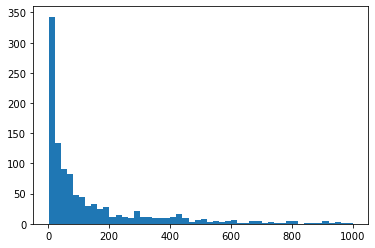

In [65]:
plt.hist(res['fic'], bins=50, range=(1, 1000));

In [70]:
res['fic'].median()

65.0

In [ ]:
max_pages

In [ ]:
conn = sqlite3.connect('scrape.db')